In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Import custom logger
sys.path.append('..')
from result_logger import log_result


# =========================================================
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# SYSTEM CHECK
print("TensorFlow Version:", tf.__version__)
# =========================================================

2026-02-02 06:50:56.982275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 06:50:57.141113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 06:51:12.025221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU Available: True
TensorFlow Version: 2.20.0


In [2]:
# =========================================================
# CONFIGURATION
# =========================================================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

PUBLIC_DIR = "../Dataset/preprocessed_Public"
SELF_DIR = "../Dataset/preprocessed_self"

CLASS_NAMES = sorted(os.listdir(PUBLIC_DIR))
NUM_CLASSES = len(CLASS_NAMES)

# Create models directory
os.makedirs('models', exist_ok=True)


print("Classes:", CLASS_NAMES)

Classes: ['test', 'train', 'val']


In [3]:
# =========================================================
# CLASS NAMES
# =========================================================
CLASS_NAMES = sorted([
    d for d in os.listdir(os.path.join(PUBLIC_DIR, "train"))
    if os.path.isdir(os.path.join(PUBLIC_DIR, "train", d))
])

NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)

Classes: ['aluminium', 'paper', 'plastic']


In [4]:
# =========================================================
# DATA GENERATORS 
# =========================================================
train_datagen = ImageDataGenerator(
    rescale=1./255   # Only normalization
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [5]:
# =========================================================
# LOAD DATA FROM DIRECTORIES
# =========================================================
train_gen = train_datagen.flow_from_directory(
    os.path.join(PUBLIC_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(PUBLIC_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(SELF_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\n📊 Dataset Summary")
print("Train samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)
print("Test samples (self):", test_gen.samples)

Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 533 images belonging to 3 classes.

📊 Dataset Summary
Train samples: 7512
Validation samples: 403
Test samples (self): 533


In [ ]:
# =========================================================
# CNN MODEL (MEMORY SAFE)
# =========================================================
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print("\n📋 Model Summary")
model.summary()


In [ ]:
# =========================================================
# CALLBACKS
# =========================================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4),
    ModelCheckpoint(
        'models/customvgg_preprocessed.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# =========================================================
# TRAINING
# =========================================================
print("\n🚀 Training started...\n")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

In [ ]:
# =========================================================
# TRAINING CURVES
# =========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc, test_prec, test_rec = model.evaluate(test_gen, verbose=0)
test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_prec*100:.2f}%")
print(f"Test Recall: {test_rec*100:.2f}%")
print(f"Test F1-score: {test_f1*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – CustomVGG CNN (Preprocessed)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Log results to CSV
log_result(
    model_name='CustomVGG_CNN',
    experiment_type='Preprocessed',
    accuracy=test_acc,
    precision=test_prec,
    recall=test_rec,
    f1=test_f1,
    loss=test_loss
)

print("✅ Evaluation completed and results logged")

# =========================================================
# LOAD SAVED MODEL (OPTIONAL)
# =========================================================
If you have already trained the model, load it instead of training again

In [ ]:
# Load saved model if it exists
def load_saved_model(model_path):
    """
    Load a saved Keras model
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model or None
    """
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        from tensorflow import keras
        model = keras.models.load_model(model_path)
        print("✓ Model loaded successfully")
        return model
    else:
        print(f"❌ Model not found at {model_path}")
        return None

# Try to load the saved model
model_path = 'models/customvgg_preprocessed.keras'
loaded_model = load_saved_model(model_path)

if loaded_model is not None:
    print("\n📊 Evaluating loaded model on test set...")
    
    # Recreate test generator
    test_gen = test_datagen.flow_from_directory(
        os.path.join(SELF_DIR, "test"),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )
    
    # Evaluate
    test_loss, test_acc, test_prec, test_rec = loaded_model.evaluate(test_gen, verbose=1)
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    
    print(f"\nLoaded Model Results:")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Precision: {test_prec*100:.2f}%")
    print(f"Test Recall: {test_rec*100:.2f}%")
    print(f"Test F1-score: {test_f1*100:.2f}%")
    
    # Log results
    log_result(
        model_name='CustomVGG_CNN',
        experiment_type='Preprocessed',
        accuracy=test_acc,
        precision=test_prec,
        recall=test_rec,
        f1=test_f1,
        loss=test_loss
    )
    
    print("✓ Results logged to final_results.csv")
else:
    print("⚠️ No saved model found. Please train the model first.")

# =========================================================
# TEST ON RAW SELF-COLLECTED DATASET
# =========================================================
Load the preprocessed model and test it on raw self-collected images

In [6]:
# =========================================================
# LOAD SAVED MODEL AND TEST ON RAW DATA
# =========================================================

# Path to saved model
model_path = 'models/customvgg_preprocessed.keras'

# Load the model
if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    from tensorflow import keras
    loaded_model = keras.models.load_model(model_path)
    print("✅ Model loaded successfully\n")
else:
    print(f"❌ Model not found at {model_path}")
    print("Please train the model first!")
    loaded_model = None

Loading model from models/customvgg_preprocessed.keras...


I0000 00:00:1769986291.100825   24718 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ Model loaded successfully



In [7]:
# =========================================================
# CREATE TEST GENERATOR FOR RAW SELF-COLLECTED DATA
# =========================================================

RAW_SELF_DIR = "../Dataset/SelfCollected_Dataset"

# Data generator with only rescaling (no augmentation)
raw_test_datagen = ImageDataGenerator(rescale=1./255)

# Load raw test data
raw_test_gen = raw_test_datagen.flow_from_directory(
    RAW_SELF_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print(f"\n📊 Raw Self-Collected Dataset Summary")
print(f"Total samples: {raw_test_gen.samples}")
print(f"Classes: {list(raw_test_gen.class_indices.keys())}")
print(f"Class distribution: {dict(zip(raw_test_gen.classes, [1]*len(raw_test_gen.classes)))}")

Found 533 images belonging to 3 classes.

📊 Raw Self-Collected Dataset Summary
Total samples: 533
Classes: ['aluminium', 'paper', 'plastic']
Class distribution: {np.int32(0): 1, np.int32(1): 1, np.int32(2): 1}


In [8]:
# =========================================================
# EVALUATE ON RAW SELF-COLLECTED DATA
# =========================================================

if loaded_model is not None:
    print("\n📊 Evaluating on RAW SELF-COLLECTED dataset...\n")
    
    # Evaluate
    test_loss, test_acc, test_prec, test_rec = loaded_model.evaluate(raw_test_gen, verbose=1)
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec + 1e-7)
    
    print(f"\n{'='*50}")
    print(f"Model: CustomVGG_CNN (Preprocessed)")
    print(f"Test Dataset: Raw Self-Collected")
    print(f"{'='*50}")
    print(f"Test Accuracy:  {test_acc*100:.2f}%")
    print(f"Test Precision: {test_prec*100:.2f}%")
    print(f"Test Recall:    {test_rec*100:.2f}%")
    print(f"Test F1-score:  {test_f1*100:.2f}%")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"{'='*50}\n")
else:
    print("⚠️ Model not loaded. Cannot evaluate.")


📊 Evaluating on RAW SELF-COLLECTED dataset...



2026-02-02 06:51:37.228278: I external/local_xla/xla/service/service.cc:163] XLA service 0x73eeac00aa10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-02 06:51:37.228305: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2026-02-02 06:51:37.273953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-02 06:51:37.368469: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801


 5/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3619 - loss: 1.1432 - precision: 0.3740 - recall: 0.3221

I0000 00:00:1769986299.508208   25193 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.3377 - loss: 1.8107 - precision: 0.3333 - recall: 0.2946

Model: CustomVGG_CNN (Preprocessed)
Test Dataset: Raw Self-Collected
Test Accuracy:  33.77%
Test Precision: 33.33%
Test Recall:    29.46%
Test F1-score:  31.27%
Test Loss:      1.8107



Generating predictions...
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

📋 Classification Report (Raw Self-Collected)
              precision    recall  f1-score   support

   aluminium       0.49      0.30      0.38       148
       paper       0.26      0.51      0.34       151
     plastic       0.41      0.25      0.31       234

    accuracy                           0.34       533
   macro avg       0.39      0.35      0.34       533
weighted avg       0.39      0.34      0.34       533



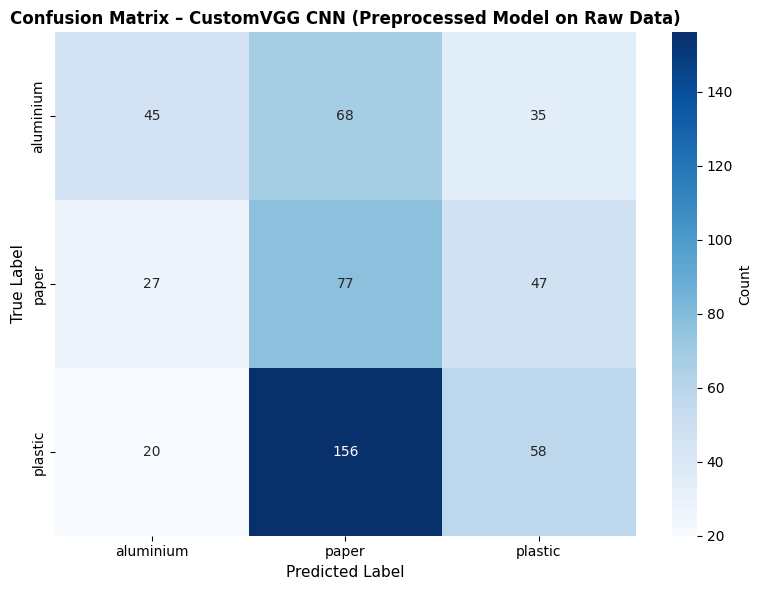

✅ Evaluation completed!


In [9]:
# =========================================================
# PREDICTIONS AND CONFUSION MATRIX
# =========================================================

if loaded_model is not None:
    # Get predictions
    print("Generating predictions...")
    y_pred_prob = loaded_model.predict(raw_test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = raw_test_gen.classes
    
    # Classification report
    print("\n📋 Classification Report (Raw Self-Collected)")
    print(classification_report(y_true, y_pred, target_names=raw_test_gen.class_indices.keys()))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=raw_test_gen.class_indices.keys(),
                yticklabels=raw_test_gen.class_indices.keys(),
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix – CustomVGG CNN (Preprocessed Model on Raw Data)', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('True Label', fontsize=11)
    plt.tight_layout()
    plt.show()
    
    print("✅ Evaluation completed!")
else:
    print("⚠️ Model not loaded. Cannot generate predictions.")

In [10]:
# =========================================================
# LOG RESULTS (OPTIONAL)
# =========================================================

# Uncomment to log results for raw data testing
if loaded_model is not None:
    log_result(
        model_name='CustomVGG_CNN',
        experiment_type='Preprocessed_on_Raw',
        accuracy=test_acc,
        precision=test_prec,
        recall=test_rec,
        f1=test_f1,
        loss=test_loss
    )
    print("✅ Results logged to final_results.csv")

✓ Results logged: CustomVGG_CNN - Preprocessed_on_Raw
  Accuracy: 0.3377, Precision: 0.3333, Recall: 0.2946, F1: 0.3127
✅ Results logged to final_results.csv
